# DeepONet: Learning the Solution Operator
Here, we use TorchPhysics and the DeepONet approach to solve the wave-equation for different intial conditions f.

\begin{align*}
    \partial_t^2 u &= 0.5 \, \partial_x^2 u, &&\text{ in } I_x \times I_t, \\
    u &= 0 , &&\text{ on } \partial I_x \times I_t, \\
    \partial_t u(\cdot, 0) &= 0 , &&\text{ in } I_x, \\
    u(\cdot, 0) &= f(x) , &&\text{ in } I_x,
\end{align*}
with $I_x = [0, 2\pi]$ and $I_t = [0, 5]$.

In [67]:
#!pip install torchaudio==0.13.0
#!pip install torchphysics

Like always, we start by defining all parameters:

In [68]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "3"
import torch
import torchphysics as tp
import pytorch_lightning as pl
import math

# Here all parameters are defined:
t_min, t_max = 0.0, 5.0
x_min, x_max = 0.0, 2 * math.pi
c = 0.5
c_root = math.sqrt(c)

# Size of the data set created for training
dataset_size = 6000

# Number of time points for discretization of D and training
N_t = 25
N_x = 200

# Training parameters
train_iterations = 2500
learning_rate = 1.e-3

To simplify our example, we will consider three different types of initial conditions. These are:
\begin{align*}
    f_1(x) &= k_1 (x - x_{min}) (x_{max} - x) / 9.0 \\
    f_2(x) &= (k_1 \sin(x) + k_2 \sin(2x) + k_3 \sin(3x)) / 3.0 \\
    f_3(x) &= f_1(x) + f_2(x)
\end{align*}
Here, $k_1, k_2, k_3$ are different random parameters that lead to different initial conditions.

Implement the initial condition $f_2$, using *torch.sin*.

In [69]:
# Three types of initial conditions:
def f1(x, k1, k2, k3):
    return k1 * (x - x_min) * (x_max - x) / 9.0

# TODO: Implement f_2
def f2(x, k1, k2, k3):
    return (k1 * torch.sin(x) + k2 * torch.sin(2*x) + k3 * torch.sin(3*x)) / 3.0

def f3(x, k1, k2, k3):
    return f1(x, k1, k2, k3) + f2(x, k1, k2, k3)

The following two cells handle the creation of the training data. They are already completed. You don't have to understand them in detail. Just run the next two cells.

In [70]:
# Parameter spaces
K1 = tp.spaces.R1('k1')
K2 = tp.spaces.R1('k2')
K3 = tp.spaces.R1('k3')

# Parameter intervals
I_k1 = tp.domains.Interval(K1, 0.5, 1.0)
I_k2 = tp.domains.Interval(K2, -1.0, 1.0)
I_k3 = tp.domains.Interval(K3, -1.0, 1.0)

# Parameter sampler
param_sampler = tp.samplers.RandomUniformSampler(I_k1*I_k2*I_k3, n_points=dataset_size)

# Create parameter samples
params = param_sampler.sample_points().as_tensor

The following cell handles the creation of the training data. You don't have to understand the procedure in detail, for a given initial condition. The method computes the expected solution at different time and space points.

You can just run the cell and proceed to next ones.

In [71]:
def create_dataset(N_t, N_x, params, Fourier_N=20, integral_N=1000):
    time_points = torch.linspace(t_min, t_max, N_t)
    space_points = torch.linspace(x_min, x_max, N_x)
    integral_points = torch.linspace(x_min, x_max, integral_N)

    u_tensor = torch.zeros((len(params), N_t, N_x))
    f_tensor = torch.zeros((len(params), N_x))
    b_coeff = torch.zeros((len(params), Fourier_N))
    f_list = [f1, f2, f3]
    for i in range(len(params)):
        f_evaluated = f_list[i%3](integral_points, *params[i])
        
        # compute coefficients of Fourier representation of f
        for k in range(Fourier_N):
            b_coeff[i, k] = torch.trapezoid(f_evaluated * torch.sin((k+1)/2.0 * integral_points))
        
        # create branch input and solution
        f_tensor[i, :] = f_list[i%3](space_points, *params[i])
    
    b_coeff *= 2.0/(integral_N - 1.0)

    space_points_repeat = space_points.reshape(1, -1).repeat((len(params), 1))

    for j in range(N_t):
        for k in range(Fourier_N):
            u_tensor[:, j, :] += b_coeff[:, k:k+1] * torch.cos(c_root*(k+1)/2.0*time_points[j]) \
                                    *torch.sin((k+1)/2.0 * space_points_repeat)  
    
    return time_points, space_points, u_tensor, f_tensor

By calling **create_dataset** we can create for each given parameter combination the solution $u$. The output is:

 - **time_points**: An equidistant time grid with $N_t$ points, where the solution has been computed.
 - **space_points**: An equidistant space grid with $N_x$ points, where the solution has been computed.
 - **u_data**: A tensor of the shape (len(params), N_t, N_x), that contains the solution for each parameter at each time and  space coordinate.
 - **f_data**: A tensor of the shape (len(params), N_x), containing the initial condition for each parameter set.


In [72]:
time_points, space_points, u_data, f_data = create_dataset(N_t, N_x, params)

We can have a look at the solution for a given parameter:

Plot one example of the dataset:


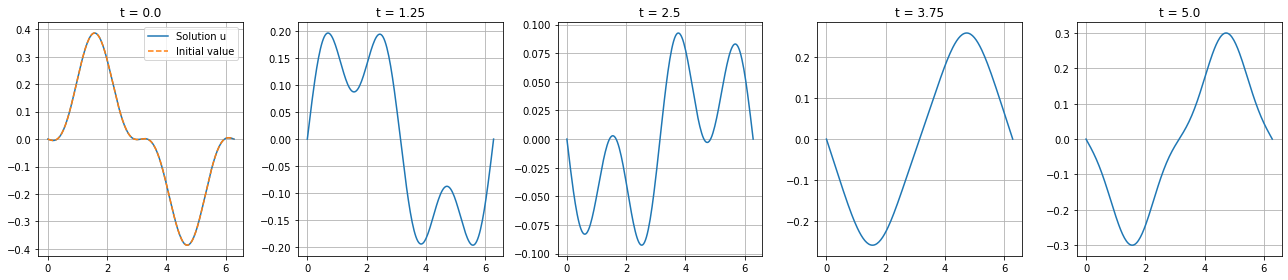

In [73]:
import matplotlib.pyplot as plt

example_idx = 121 # between 0 and dataset_size

print("Plot one example of the dataset:")
plt.figure(figsize=(18, 4))
plt_idx = 1

for j in [0.0, (N_t-1)/4, (N_t-1)/2, 3*(N_t-1)/4, N_t-1]:
    plt.subplot(1, 5, plt_idx)
    plt.plot(space_points, u_data[example_idx, int(j), :])
    plt.grid()
    plt.title("t = " + str(time_points[int(j)].item()))
    if plt_idx == 1:
        plt.plot(space_points, f_data[example_idx], linestyle="--")
        plt.legend(["Solution u", "Initial value"])
    plt_idx += 1
plt.tight_layout()

Next, we split the data in a training and test set. The training set will be seen by the neural network while training. The test set will be used to evaluate the performance of the network on unseen data.

We want to use, at the start, 50% of our data in the training. Set the constant below to the corresponding value.

In [74]:
train_data_size = int(0.5 * dataset_size) # TODO: Set to 50% of complete dataset length

# Split data:
# TODO: Split the data for the initial values, which are saved in f_data, like it is shown for u_data.
u_tensor_train = u_data[:train_data_size]
f_tensor_train = f_data[:train_data_size]
u_tensor_test = u_data[train_data_size:]
f_tensor_test = f_data[train_data_size:]

### TODO: Bonus task (after you tried to train the network once without noice)
### Study how the learned solution behaves, if we add noise to the training data:
#noise = 0.05
#u_tensor_train += noise * torch.max(torch.abs(u_tensor_train)) * torch.randn_like(u_tensor_train)
#f_tensor_train += noise * torch.max(torch.abs(f_tensor_train)) * torch.randn_like(f_tensor_train)

Next, we start with the TorchPhysics part. The first definitions are known and similiar to the other examples.

In [75]:
# TODO: Define all spaces (for the time, space, the solution u and the initial value f) 
T = tp.spaces.R1('t') # input variable
X = tp.spaces.R1('x') # input variable
U = tp.spaces.R1('u') # output variable
F = tp.spaces.R1('f') # function name for the initial values

# Domain
int_x = tp.domains.Interval(X, x_min, x_max)
int_t = tp.domains.Interval(T, t_min, t_max)

In [76]:
# The Branch net of the DeepONets gets a function as an input. This function belongs to a given space, 
# that we define at the start. The space is similar to the spaces above, but it also knows the input values
# of the functions belong to this space:
Fn_space = tp.spaces.FunctionSpace(int_x, F)

# To discretize the initial functions, we use the following sampler, that just returns our space_points from above:
discretization_sampler = tp.samplers.DataSampler(tp.spaces.Points(space_points.reshape(-1, 1), X))

In [77]:
# Here we build the DeepONet, that consists of a fully connected Trunk and Branch net:
# TODO: Add the correct input, output and functionspaces at the positions marked with ...
#       Set the size of the hidden layers of the branch_net to (50, 20, 20, 20, 50) and of the 
#       trunk_net to (20, 30, 30, 30, 30, 40).


output_neurons = 100 # for Trunk and Branch

branch_net = tp.models.FCBranchNet(function_space=Fn_space,  
                                   discretization_sampler=discretization_sampler, 
                                   hidden=(50, 20, 20, 20, 50))
trunk_net  = tp.models.FCTrunkNet(input_space=T*X, hidden=(20, 30, 30, 30, 30, 40))
deep_O_net = tp.models.DeepONet(trunk_net, branch_net, 
                                output_space=U, 
                                output_neurons=output_neurons)

In [78]:
# Now, we have to create the trainigs condition for the DeepONet. 
# First, we collect our data into an object that loads and sends it the GPU:

# First creating a meshgrid of time and space:
input_tensor = torch.zeros((N_t*N_x, 2))
input_tensor[:, 0] = torch.repeat_interleave(time_points, N_x)
input_tensor[:, 1] = space_points.repeat(N_t)

# We split here the branch and trunk into batches. Each training step another batch will be used.
branch_batch_size = len(u_tensor_train) // 3
trunk_batch_size  = len(input_tensor) // 3

dataloader = tp.utils.DeepONetDataLoader(f_tensor_train.reshape(train_data_size, -1, 1), 
                                         input_tensor, 
                                         u_tensor_train.reshape(train_data_size, -1, 1), 
                                         F, T*X, U,
                                         branch_batch_size, trunk_batch_size)


In [79]:
# The above Dataloader can be used in a TorchPhysics condition. 
# Here, we just have to compare the output of the model with the expected
# data. This is handled in the "DeepONetDataCondition".
# TODO: Add the missing arguments. Here, we want to use the root of the MSE, so set norm=2 and root=2
data_condition = tp.conditions.DeepONetDataCondition(module=deep_O_net, 
                                                     dataloader=dataloader,
                                                     norm=2,
                                                     root=2)

Finally, we can start the training. In the examples before we used only one fixed learning rate, generally it is helpful to reduce the learning rate in the training process. 
In the following, this is done with a for-loop and by stopping and restarting the training with a different learning rate. There are more efficient ways, like schedulers, but for this simple example the for-loop is sufficient. 

In [80]:
# Start training
for lr in [1.e-3, 5.e-4, 1.0e-4]:
    optim = tp.OptimizerSetting(optimizer_class=torch.optim.Adam, lr=lr) 
    solver = tp.solver.Solver([data_condition], optimizer_setting=optim)


    trainer = pl.Trainer(gpus=1,
                        num_sanity_val_steps=0,
                        benchmark=True,
                        max_steps=train_iterations,
                        logger=False, 
                        enable_checkpointing=False
                        )

    trainer.fit(solver)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 26.9 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
26.9 K    Trainable params
0         Non-trainable params
26.9 K    Total params
0.108     Total estimated model params size (MB)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarning: The dataloader, train dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 32 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.
  warnings.warn(*args, **kwargs)
/home/tomfre/miniconda3/envs/bosch/lib/python3.9/site-packages/pytorch_lightning/utilities/distributed.py:69: UserWarnin

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 26.9 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
26.9 K    Trainable params
0         Non-trainable params
26.9 K    Total params
0.108     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [3]

  | Name             | Type       | Params
------------------------------------------------
0 | train_conditions | ModuleList | 26.9 K
1 | val_conditions   | ModuleList | 0     
------------------------------------------------
26.9 K    Trainable params
0         Non-trainable params
26.9 K    Total params
0.108     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

The training itself was rather short, and the network has not completely converged yet, but for our small exercise this will be enough. 

We can check the error on the test set, that should be around 5-10%.

In [81]:
### Check error on test set:
f_tensor_test = f_tensor_test[:5000]
u_tensor_test = u_tensor_test[:5000]
u_model = deep_O_net(tp.spaces.Points(input_tensor, T*X), f_tensor_test.reshape(-1, N_x, 1)).as_tensor
error = torch.abs(u_model - u_tensor_test.reshape(len(f_tensor_test), -1, 1))
print("Max. absolute error on test set is:", torch.max(error).item())
print("Relative error is:", torch.max(error).item() / torch.max(torch.abs(u_tensor_test)).item())

Max. absolute error on test set is: 0.8490055799484253
Relative error is: 0.46479007071268647


We can also plot the learned solution of the network and can see, that the generall behavoir is already learned.

Plot one example of the dataset:


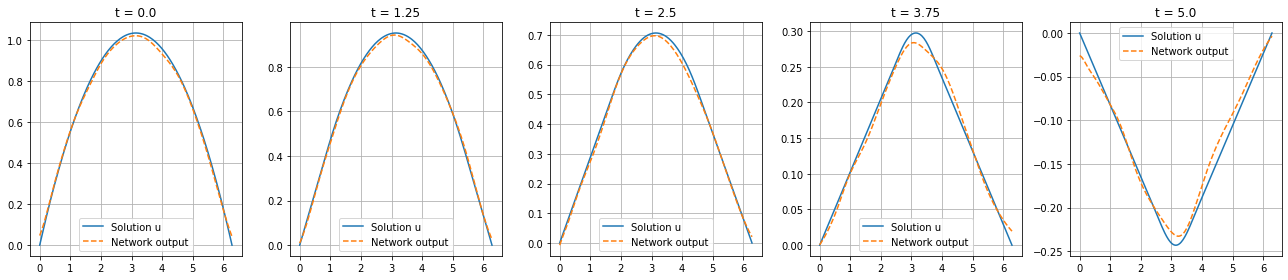

In [82]:
### Plot a solution:
example_idx = 335 # between 0 and (dataset_size - train_data_size)

print("Plot one example of the dataset:")
plt.figure(figsize=(18, 4))
plt_idx = 1

branch_input = f_tensor_test[example_idx:example_idx+1].reshape(-1, N_x, 1)
u_model = deep_O_net(tp.spaces.Points(input_tensor, T*X), branch_input).as_tensor.detach()

for j in [0.0, (N_t-1)/4, (N_t-1)/2, 3*(N_t-1)/4, N_t-1]:
    plt.subplot(1, 5, plt_idx)
    plt.plot(space_points, u_tensor_test[example_idx, int(j), :])
    plt.plot(space_points, u_model[0, int(j*N_x):int((j+1)*N_x)], linestyle="--")
    plt.grid()
    plt.title("t = " + str(time_points[int(j)].item()))
    plt.legend(["Solution u", "Network output"])
    plt_idx += 1
plt.tight_layout()